In [ ]:
# VERSION 1: DATA INTEGRITY SYSTEM DESIGN & DATA CONSISTENCY, ROOT CAUSE SIMULATION

# A. Create sample dataset
import os
import pandas as pd
os.makedirs("Weekly_Uploaded", exist_ok=True)

operational = pd.DataFrame({"batch_id": ["B001", "B002", "B003"],
    "date": ["2025-10-01", "2025-10-02", "2025-10-03"],
    "shift": [1, 2, 1],
    "egg_weight_g": [20.5, 21.1, 20.8],
    "larvae_age_day": [5, 5, 6],
    "larvae_weight_kg": [400, 420, 410],
    "feed_intake_kg": [250, 260, 255],
    "mortality_rate": [0.03, 0.02, 0.04],
    "drying_temp_avg": [105, 107, 102],
    "drying_duration_min": [180, 175, 185],
    "moisture_after_dry": [9.2, 8.8, 9.5],
    "output_kg": [320, 350, 300],
    "defect_kg": [2, 1, 3],
    "operator": ["Anh", "Bình", "Cường"]
})
operational.to_csv("Weekly_Uploaded/Operational_Data_2025W41.csv", index=False)

mes = pd.DataFrame({
    "batch_id": ["B001", "B002", "B003"],
    "sensor_id": ["S01", "S02", "S03"],
    "avg_temp": [105.5, 107.1, 101.8],
    "humidity": [45, 50, 48],
    "drying_time_min": [182, 174, 187],
    "chamber_id": ["C1", "C2", "C3"],
    "vibration_alert": [0, 0, 1]
})
mes.to_csv("Weekly_Uploaded/MES_Data_2025W41.csv", index=False)

accounting = pd.DataFrame({
    "batch_id": ["B001", "B002", "B003"],
    "feed_cost": [120, 125, 118],
    "electricity_cost": [50, 48, 55],
    "maintenance_cost": [15, 18, 16],
    "labor_cost": [45, 47, 46],
    "packaging_cost": [10, 12, 11],
    "total_cost": [240, 250, 246],
    "cost_date": ["2025-10-03", "2025-10-04", "2025-10-05"]
})
accounting.to_csv("Weekly_Uploaded/Accounting_Data_2025W41.csv", index=False)

logistics = pd.DataFrame({
    "batch_id": ["B001", "B002", "B003"],
    "truck_id": ["T01", "T02", "T03"],
    "shipment_date": ["2025-10-04", "2025-10-05", "2025-10-06"],
    "destination": ["HCMC", "Dong Nai", "Ba Ria"],
    "delivery_status": ["Delivered", "Delivered", "Delayed"],
    "weight_kg": [320, 350, 300],
    "delay_hour": [0, 0, 12],
    "driver_name": ["Hưng", "Đạt", "Tâm"]
})
logistics.to_csv("Weekly_Uploaded/Logistics_Data_2025W41.csv", index=False)
print("✅ Sample datasets created successfully in 'Weekly_Uploaded/' folder!")

!ls Weekly_Uploaded

# B. Coding

# 1. File Detection & Initialization
import pandas as pd
import os
from datetime import datetime
import pytz

validation_log_path = os.path.join('Validation_Log.csv')
if not os.path.exists(validation_log_path):
  log_df = pd.DataFrame(columns= ['File_Name', 'File_Type', 'Upload_Date', 'Upload_By', 'Status', 'Error_Message'])
  log_df.to_csv('Validation_Log.csv', index= False)
  print('Created Validation_Log.csv')
else:
  print('Validation_Log.csv already exists')

# 2. File Validation
files = os.listdir('Weekly_Uploaded')
required_files = ['Operational_Data', 'MES_Data', 'Accounting_Data', 'Logistics_Data']
detected_files = ["_".join(r.split("_")[:2]) for r in files]
print(detected_files)
missing = [r for r in required_files if r not in detected_files]

uploader = input('Enter your name and department: ')
vn_tz = pytz.timezone('Asia/Ho_Chi_Minh')
if missing:
  log_entry = {'File_Name': ', '.join(missing), 'File_Type': '/ '.join(missing), 'Upload_Date': datetime.now(vn_tz).strftime("%Y-%m-%d %H:%M:%S"), 'Upload_By': uploader, 'Status': 'Failed', 'Error_Message': f'Missing: {missing}'}
  pd.DataFrame([log_entry]).to_csv(validation_log_path, mode= 'a', index= False, header= False)
  print(f'Missing files: {missing}. Process stopped')
  raise SystemExit
else:
  print('All files detected. Proceeding to validation')

import re
expected_schema = {"Operational_Data": ["batch_id", "date", "shift", "egg_weight_g", "larvae_age_day", "larvae_weight_kg", "feed_intake_kg", "mortality_rate", "drying_temp_avg", "drying_duration_min", "moisture_after_dry", "output_kg", "defect_kg", "operator"], "MES_Data": ["batch_id", "sensor_id", "avg_temp", "humidity", "drying_time_min", "chamber_id", "vibration_alert"], "Accounting_Data": ["batch_id", "feed_cost", "electricity_cost", "maintenance_cost", "labor_cost", "packaging_cost", "total_cost", "cost_date"], "Logistics_Data": ["batch_id", "truck_id", "shipment_date", "destination", "delivery_status", "weight_kg", "delay_hour", "driver_name"]}
pattern = r'_\d{4}W\d{2}\.csv$'
current_year = datetime.now().year
current_week = datetime.now().isocalendar().week
week_str = f'{current_year}W{current_week:02d}'
for f in os.listdir('Weekly_Uploaded'):
  if not f.endswith('.csv'):
    log_entry = {'File_Name': f, 'File_Type': 'Unknown', 'Upload_Date': datetime.now(vn_tz).strftime("%Y-%m-%d %H:%M:%S"), 'Upload_By': uploader, 'Status': 'Failed', 'Error_Message': 'File is not csv format'}
    pd.DataFrame([log_entry]).to_csv(validation_log_path, mode= 'a', index= False, header= False)
    print(f'Skipped. Not a csv file')
    continue
  if not re.search(pattern, f):
    new_name = f'{f.split('.')[0]}_{week_str}.csv'
    os.rename(os.path.join('Weekly_Uploaded', f), os.path.join('Weekly_Uploaded', new_name))
    f = new_name
    log_entry = {'File_Name': f, 'File_Type': 'Auto renamed', 'Upload_Date': datetime.now(vn_tz).strftime("%Y-%m-%d %H:%M:%S"), 'Upload_By': uploader, 'Status': 'Warning', 'Error_Message': 'File renamed to match naming convention'}
    pd.DataFrame([log_entry]).to_csv(validation_log_path, mode='a', index=False, header=False)

  file_type = '_'.join(f.split('_')[:2])
  df = pd.read_csv(os.path.join('Weekly_Uploaded', f))
  expected_cols = expected_schema.get(file_type, [])
  missing_cols = [c for c in expected_cols if c not in df.columns]

  if missing_cols:
    log_entry = {'File_Name': f, 'File_Type': file_type, 'Upload_Date': datetime.now(vn_tz).strftime("%Y-%m-%d %H:%M:%S"), 'Upload_By': uploader, 'Status': 'Failed', 'Error_Message': f'Missing: {missing_cols}'}
    pd.DataFrame([log_entry]).to_csv(validation_log_path, mode = 'a', index= False, header= False)
    print(f'Skipped. Missing column {missing_cols}')
    continue
  else:
    print('Passed schema validation')

# 3. Data Cleaning
import numpy as np
cleaned_dir = 'Clean_Data'
os.makedirs(cleaned_dir, exist_ok= True)

def cleaned_file(file_path, file_type):
  df = pd.read_csv(file_path)
  df.columns = df.columns.str.strip().str.lower()
  df.dropna(how= 'all', inplace= True)
  for col in df.columns:
    if 'date' in col:
      df[col] = pd.to_datetime(df[col], errors= 'coerce')
    elif df[col].dtype == 'object':
      df[col] = df[col].astype(str).str.strip()
  numeric_col = df.select_dtypes(include= np.number).columns
  for col in numeric_col:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    outliers = (df[col] < q1 - 1.5 * iqr)|(df[col] > q3 + 1.5 * iqr)
    df.loc[outliers, f'{col}_flag'] = 'Outlier'
  cleaned_path = os.path.join(cleaned_dir, os.path.basename(file_path).replace('.csv', '_cleaned.csv'))
  df.to_csv(cleaned_path, index= False)
  log_entry = {'File_Name': os.path.basename(cleaned_path), 'File_Type': file_type, 'Upload_Date': datetime.now(vn_tz).strftime("%Y-%m-%d %H:%M:%S"), 'Upload_By': uploader, 'Status': 'Cleaned', 'Error_Message': 'Outliers flagged' if any(df.filter(like='_flag').count()) else 'OK'}
  pd.DataFrame([log_entry]).to_csv(validation_log_path, mode= 'a', index= False, header= False)
  return cleaned_path

# 4. Append Clean Data
master_dir = 'Master_Data'
os.makedirs(master_dir, exist_ok= True)

def append_to_master(cleaned_path, file_type):
  master_file = os.path.join(master_dir, f'Master_{file_type.split('_')[0]}.csv')
  cleaned_df = pd.read_csv(cleaned_path)
  if os.path.exists(master_file):
    master_df = pd.read_csv(master_file)
    combined_df = pd.concat([master_df, cleaned_df], ignore_index= True)
  else:
    combined_df = cleaned_df
  combined_df.drop_duplicates(subset= ['batch_id'], keep= 'last', inplace= True)
  combined_df.to_csv(master_file, index= False)
  log_entry = {'File_Name': os.path.basename(master_file), 'File_Type': file_type, 'Upload_Date': datetime.now(vn_tz).strftime("%Y-%m-%d %H:%M:%S"), 'Upload_By': uploader, 'Status': 'Appended to Master', 'Error_Message': ''}
  pd.DataFrame([log_entry]).to_csv(validation_log_path, mode= 'a', index= False, header= False)

# 5. Merge Master Files
def merge_all_master():
  try:
    operational = pd.read_csv(os.path.join(master_dir, 'Master_Operational.csv'))
    mes = pd.read_csv(os.path.join(master_dir, 'Master_MES.csv'))
    accounting = pd.read_csv(os.path.join(master_dir, 'Master_Accounting.csv'))
    logistics = pd.read_csv(os.path.join(master_dir, 'Master_Logistics.csv'))
    for df in [operational, mes, accounting, logistics]:
      df.drop_duplicates(subset= ['batch_id'], keep= 'last', inplace= True)
    merged = operational.merge(mes, on= 'batch_id', how= 'left')\
    .merge(accounting, on= 'batch_id', how= 'left')\
    .merge(logistics, on= 'batch_id', how= 'left')
    merged.to_csv('Master_Data_All.csv', index= False)
    print('Merge Successfully -> Master_Data_All.csv')
    log_entry = {'File_Name': 'Master_Data_All.csv', 'File_Type': 'Merged Dataset', 'Upload_Date': datetime.now(vn_tz).strftime("%Y-%m-%d %H:%M:%S"), 'Upload_By': uploader, 'Status': 'Merged', 'Error_Message': ''}
    pd.DataFrame([log_entry]).to_csv(validation_log_path, mode= 'a', index= False, header= False)
  except Exception as e:
    log_entry = {'File_Name': 'Master_Data_All.csv', 'File_Type': 'Merged Dataset', 'Upload_Date': datetime.now(vn_tz).strftime("%Y-%m-%d %H:%M:%S"), 'Upload_By': uploader, 'Status': 'Failed', 'Error_Message': str(e)}
    pd.DataFrame([log_entry]).to_csv(validation_log_path, mode= 'a', index= False, header= False)
    print(f'Merge Failed: {e}')

for f in os.listdir('Weekly_Uploaded'):
  file_type = '_'.join(f.split('_')[:2])
  path = os.path.join('Weekly_Uploaded', f)
  if file_type in expected_schema.keys():
    cleaned_path = cleaned_file(path, file_type)
    append_to_master(cleaned_path, file_type)
merge_all_master()

# 6. Check result
from google.colab import files
files.download('Master_Data_All.csv')
files.download('Validation_Log.csv')

✅ Sample datasets created successfully in 'Weekly_Uploaded/' folder!
Accounting_Data_2025W41.csv  MES_Data_2025W41.csv
Logistics_Data_2025W41.csv   Operational_Data_2025W41.csv
Validation_Log.csv already exists
['Accounting_Data', 'Logistics_Data', 'Operational_Data', 'MES_Data']
Enter your name and department: Navin
All files detected. Proceeding to validation
Passed schema validation
Passed schema validation
Passed schema validation
Passed schema validation
Merge Successfully -> Master_Data_All.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# VERSION 2: ROOT CAUSE SIMULATION
from google.colab import files
import pandas as pd
import numpy as np
files.upload()

## Define acceptable range
df = pd.read_csv('Master_Data_All.csv')
df['yield_pct'] = df['output_kg'] / df['larvae_weight_kg']
mean_yield = df['yield_pct'].mean()
std_yield = df['yield_pct'].std()
df['expected_low'] = mean_yield - 1.5 * std_yield
df['expected_high'] = mean_yield + 1.5 * std_yield

## Apply rule-based conditions
conditions = [(df['yield_pct'] < df['expected_low']) | (df['yield_pct'] > df['expected_high']), (df['mortality_rate'] > 0.05), (df["drying_temp_avg"] > 110) | (df["drying_temp_avg"] < 95), (df["drying_duration_min"] > 190) | (df["drying_duration_min"] < 160), (df["moisture_after_dry"] > 10), (df["defect_kg"] > 3), (df["delivery_status"] == "Delayed")]
reasons = ['Yield out of range', 'High mortality rate', 'Abnormal drying temperature', 'Abnormal drying duration', 'High moisture after dry', 'Excessive defect weight', 'Delivery delayed']

root_cause_list = []
for i, c in enumerate(conditions):
  sub = df.loc[c, ["batch_id", "yield_pct", "mortality_rate", "drying_temp_avg", "drying_duration_min", "moisture_after_dry", "defect_kg", "delivery_status"]].copy()
  sub['Root_Cause'] = reasons[i]
  root_cause_list.append(sub)

## Generate reports
if root_cause_list:
  report = pd.concat(root_cause_list, ignore_index= True)
else:
  report = pd.DataFrame(columns= ['batch_id', 'Root_Cause'])
report.drop_duplicates(subset= ['batch_id', 'Root_Cause'], inplace= True)
report.to_csv('Root_Cause_Report.csv', index= False)
print('Root Cause Report generated successfully')

from datetime import datetime
import pytz
vn_tz= pytz.timezone('Asia/Ho_Chi_Minh')

## Log activity to Validation_Log.csv
log_entry = {"File_Name": "RootCause_Report.csv", "File_Type": "Root Cause Analysis", "Upload_Date": datetime.now(vn_tz).strftime("%Y-%m-%d %H:%M:%S"), "Upload_By": "Vy – Data Analyst", "Status": "Generated", "Error_Message": ""}
pd.DataFrame([log_entry]).to_csv('Validation_Log.csv',mode= 'a', index= False, header= False)

summary = report['Root_Cause'].value_counts().reset_index()
summary.columns = ['Root_Cause', 'Count']
summary.to_csv('Root_Cause_Summary.csv', index= False)
files.download('Root_Cause_Report.csv')
files.download('Root_Cause_Summary.csv')

Saving Master_Data_All.csv to Master_Data_All.csv
Root Cause Report generated successfully


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving Master_Data_All_Simulation.csv to Master_Data_All_Simulation (3).csv
cost_per_kg           1.000000
moisture_after_dry    0.164550
electricity_cost      0.087254
maintenance_cost      0.005306
feed_cost            -0.017048
labor_cost           -0.082245
packaging_cost       -0.132499
mortality_rate       -0.159752
drying_temp_avg      -0.291865
yield_pct            -0.683849
Name: cost_per_kg, dtype: float64


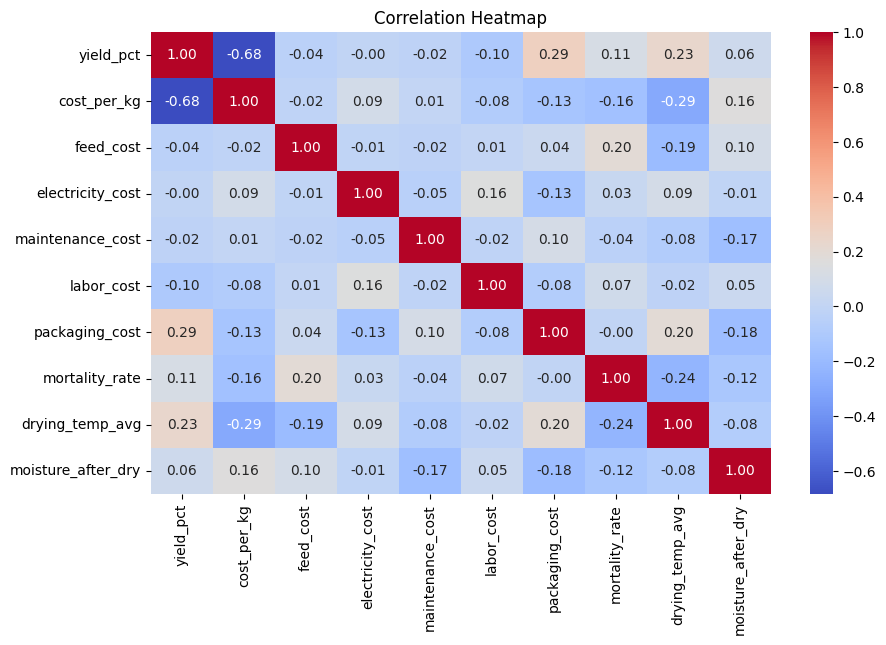

Top 5 factors
cost_per_kg           1.000000
yield_pct             0.683849
drying_temp_avg       0.291865
moisture_after_dry    0.164550
mortality_rate        0.159752
Name: cost_per_kg, dtype: float64


In [5]:
from google.colab import files
files.upload()
import pandas as pd
df = pd.read_csv('Master_Data_All_Simulation.csv', low_memory= False, encoding= 'utf-8-sig')

# Filter cost driver variables
related_cols = ['batch_id', 'feed_intake_kg', 'output_kg', 'feed_cost', 'electricity_cost', 'maintenance_cost', 'labor_cost', 'packaging_cost', 'total_cost', 'mortality_rate', 'drying_temp_avg', 'moisture_after_dry']
df = df[related_cols]

# Create important variables
df['yield_pct'] = df['output_kg'] / df['feed_intake_kg']
df['cost_per_kg'] = df['total_cost'] / df['output_kg']

# Correlation & Heatmap
corr = df[['yield_pct', 'cost_per_kg', 'feed_cost', 'electricity_cost', 'maintenance_cost', 'labor_cost', 'packaging_cost', 'mortality_rate', 'drying_temp_avg', 'moisture_after_dry']].corr()
print(corr['cost_per_kg'].sort_values(ascending= False))

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize= (10, 6))
sns.heatmap(corr, annot= True, cmap= 'coolwarm', fmt= '.2f')
plt.title('Correlation Heatmap')
plt.show()

print('Top 5 factors')
top_5_factors = print(corr['cost_per_kg'].abs().sort_values(ascending= False).head(5))

**VERSION 1: DATA INTEGRITY SYSTEM DESIGN & DATA CONSISTENCY, ROOT CAUSE SIMULATION**

_**1. File Detection & Initialization**_

- Monitor folder /Weekly_Uploaded/ for new .csv files.
- Validate presence of all 4 required domains (Operational_Data, MES_Data, Accounting_Data, Logistics_Data).
- Auto-create log file Validation_Log.csv if missing.
- Naming pattern enforced: <FileType>_YYYYW##.csv → e.g. MES_Data_2025W41.csv.
- If fewer than 4 files detected → stop pipeline & log “Incomplete Upload” status.

_**2. File Validation**_

- Each file passes through schema and format validation:
  + Check file type: ensure .csv format, rename automatically if needed.
  + Check schema: compare columns against expected templates.
  + Log errors to Validation_Log.csv if missing columns or mismatched schema.

| File Type   | Expected Columns                                                                                                                                                                                |
| ----------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Operational | batch_id, date, shift, egg_weight_g, larvae_age_day, larvae_weight_kg, feed_intake_kg, mortality_rate, drying_temp_avg, drying_duration_min, moisture_after_dry, output_kg, defect_kg, operator |
| MES         | batch_id, sensor_id, avg_temp, humidity, drying_time_min, chamber_id, vibration_alert                                                                                                           |
| Accounting  | batch_id, feed_cost, electricity_cost, maintenance_cost, labor_cost, packaging_cost, total_cost, cost_date                                                                                      |
| Logistics   | batch_id, truck_id, shipment_date, destination, delivery_status, weight_kg, delay_hour, driver_name                                                                                             |

_**3. Data Cleaning**_

- Normalize column names → lowercase & trim spaces.
- Remove blank rows.
- Standardize data types (date, numeric, string).
- Detect outliers using IQR method (Interquartile Range).
- Export cleaned files → /Clean_Data/.
- Output: [FileType]_cleaned.csv

_**4. Master Data Appending**_

- Each cleaned dataset is appended to its corresponding master dataset:

| Cleaned File                 | Master Target          |
| ---------------------------- | ---------------------- |
| Operational_Data_cleaned.csv | Master_Operational.csv |
| MES_Data_cleaned.csv         | Master_MES.csv         |
| Accounting_Data_cleaned.csv  | Master_Accounting.csv  |
| Logistics_Data_cleaned.csv   | Master_Logistics.csv   |

- Remove duplicates by batch_id (keep latest).
- Log results: “Appended to Master”.

_**5. Master Merging**_

- Merge all 4 master files on batch_id (LEFT JOIN) to create one consolidated dataset: Operational + MES + Accounting + Logistics → Master_Data_All.csv
- Output: Master_Data_All.csv — base for analytical dashboards.

_**6. Weekly Validation Log & Escalation**_

- All operations (validation, cleaning, merging) are logged into Validation_Log.csv with timestamp and status.
- This ensures traceability for future audits or automation.